In [37]:
import numpy as np
from PIL import Image
from astropy.table import Table
import os
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from astropy.io import fits
from astropy.wcs import WCS


def lupton04_pil_format(images, scales=(1., 1., 1.), beta=1.):
    """
    Parameters:
    - images: List of image channels (R, G, B)
    - scales: Tuple of scaling factors for each channel
    - beta: Parameter for the arcsinh function

    Output:
    - List of RGB tuples in PIL format
    """
    r = images[0] * scales[0]
    g = images[1] * scales[1]
    b = images[2] * scales[2]

    I = (r + g + b) / 3.
    print(np.min(I))
    print(np.max(I))
    f = np.arcsinh(I / beta)

    R = r * f / I
    G = g * f / I
    B = b * f / I

    M = max(R.max(), G.max(), B.max())

    R = R / M * 255.
    G = G / M * 255.
    B = B / M * 255.

    R[R < 0.] = 0.
    G[G < 0.] = 0.
    B[B < 0.] = 0.

    flatlist = []
    for img in [R, G, B]:
        img = np.uint8(img.round())
        img = np.flipud(img)
        flatlist.append(img.flatten())

    result = []
    for i in range(images[0].size):
        result.append((flatlist[0][i], flatlist[1][i], flatlist[2][i]))

    return result


def make_crazy_pil_format(data, cuts):
    """
    Parameters:
    - data: List of image channels (R, G, B)
    - cuts: Tuple of percentiles for each channel

    Output:
    - List of RGB tuples in PIL format
    """
    newlist = []
    for i in range(3):
        flatd = np.flipud(data[i]).flatten()
        flatd[flatd < 0.] = 0.
        flatd *= 255. / cuts[i]
        flatd[flatd > 255.] = 255.
        flatd = np.uint8(flatd.round())
        newlist.append(flatd)

    l = []

    for i in range(data[0].size):
        l.append((newlist[0][i], newlist[1][i], newlist[2][i]))

    return l



In [33]:
# Default RGB bands and settings
rgbbands = ('i', 'r', 'g') 
scales = np.array([0.5, 0.6, 1.8]) / 10.**(-2./5.*27.)
alpha = 0.02
Q = 8.

def display_png(path_png):
    """
    Display PNG image from the given path.

    Parameters:
        path_png (str): Path to the PNG image file.
    """
    print(path_png)
    img = mpimg.imread(path_png)
    imgplot = plt.imshow(np.flip(img, axis=0))
    plt.show()


In [34]:
def load_fits(image_file):
    """
    Load FITS file data.

    Parameters:
    - image_file (str): Path to the FITS file.

    Returns:
    - HDUList: FITS file data.
    """
    
    return fits.open(image_file)

def has_dimension_three(arr):
    """
    Check if the input array has three dimensions.

    Parameters:
        arr (numpy.ndarray): Input array.

    Returns:
        bool: True if the array has three dimensions, False otherwise.
    """
    return arr.ndim >= 3 and 3 in arr.shape

In [35]:
def make_rgb_one_image(img_array=None , img_name=None, tile_name=None, 
                       folder_cutouts=None, display_plot=False, 
                       return_img=False, type_plot='lupton', save_img=False, path_to_save=None ):
    
    """
    Create an RGB image from FITS files or provided image array.

    Parameters:
        img_array (numpy.ndarray): Image data array. If not provided, img_name and tile_name must be provided.
        img_name (str): ID of the image.
        tile_name (str): ID of the tile.
        folder_cutouts (str): Path to the folder containing FITS files.
        display_plot (bool): Whether to display the RGB image plot.
        return_img (bool): Whether to return the RGB image as a NumPy array.
        type_plot (str): Type of RGB plot ('marshall' or 'lupton').
        save_img (bool): Whether to save the RGB image.
        path_to_save (str): Path to save the RGB image if save_img is True.

    Returns:
        np.ndarray: RGB image as a NumPy array if return_img is True.
    """

    if img_array is None:
        if (img_name is not None) and (tile_name is not None):
            # Load image from file
            if not img_name.endswith('.fits'):
                img_name = img_name+'.fits'

            rgbdata = []
            for band in rgbbands:
                try:
                    img_to_display = os.path.join(folder_cutouts, band+'_band', 'tile_'+change_specialcharacters(tile_name), img_name)
                    img_array = fits.getdata(img_to_display, memmap=True)
                except:
                    try:
                        img_to_display = os.path.join(folder_cutouts, band+'_band', change_specialcharacters(tile_name), img_name)
                
                    except FileNotFoundError:
                        print('in HD_MG')
                        img_to_display = os.path.join('/home/grespanm/mnt/HD_MG/KiDS_cutout', band+'_band', change_specialcharacters(tile_name), img_name)

                img_array = fits.getdata(img_to_display, memmap=True)
                rgbdata.append(img_array)
             
        else:
            raise ValueError("Either 'img_name' and 'tile_name' or 'img_array' must be provided.")
    else:

        # Create a new array with the third dimension in the order i,r,g
        rgbdata = img_array#[[1, 0, 2], :, :]
        img_array = img_array[0,:,:]
        
       

    s = img_array.shape
   
    im = Image.new('RGB', (s[1], s[0]), 'black')
    if type_plot== 'marshall':
        im.putdata(marshall16_pil_format(rgbdata, scales=scales, alpha=alpha, Q=Q))
    elif type_plot=='lupton':
        im.putdata(lupton04_pil_format(rgbdata, scales=scales))
    else:
        raise ValueError('type_plot error, available values marshall and lupton')
    #if (img_name is not None) and (tile_name is not None):
    if save_img:
        if (img_name is None) and (tile_name is None):
            raise ValueError('If you want to save the image give tile name and image name!')
        if path_to_save is None:
            raise ValueError('If you want to save the image you need to give the path (parent directory) to save it.')
        name_to_save =tile_name+'_ID_'+'.'.join(img_name.split('.')[:-1])
        pp_save=os.path.join(path_to_save,'RGB_images')

        if not os.path.exists(pp_save):
            os.mkdir(pp_save)
        pp_save = os.path.join(pp_save, name_to_save+'.png')
        im.save(pp_save)

    if display_plot:
        fig, ax = plt.subplots(figsize=(5, 5)) 
        # Convert the PIL image to a NumPy array
        np_image = np.array(im)
        # Display the NumPy array as an image with Matplotlib
        plt.imshow(np_image)
        plt.axis('off')
        plt.show()

    if return_img:
        return np.array(im)

In [20]:
path= 'manga/manga-7443-12703-LOGCUBE.fits'

In [21]:
hdu = load_fits(os.path.join(path))

In [22]:
#g,r,i
img_t = []
#i,r,g
for i in [14,13,12]:
    img_t.append(hdu[i].data)
img_t = np.array(img_t)

In [23]:
img_t.shape

(3, 74, 74)

In [24]:
import numpy as np
from sklearn.preprocessing import StandardScaler

# Define the small epsilon value
epsilon = 1e-10

# Replace zeros with epsilon value
img_t_nonzero = np.where(img_t == 0, epsilon, img_t)




In [25]:
# Assuming img_t is your array of shape (3, 74, 74)
# Extracting a square portion centered in the image with edges of length 50
center_x = img_t.shape[1] // 2
center_y = img_t.shape[2] // 2
edge_length = 20

# Define the boundaries for slicing
x_start = center_x - edge_length // 2
x_end = center_x + edge_length // 2
y_start = center_y - edge_length // 2
y_end = center_y + edge_length // 2

# Extract the square portion
square_img = img_t[:, x_start:x_end, y_start:y_end]

img_t_nonzero = np.where(square_img == 0, epsilon, square_img)


16407975000.0
365036340000.0


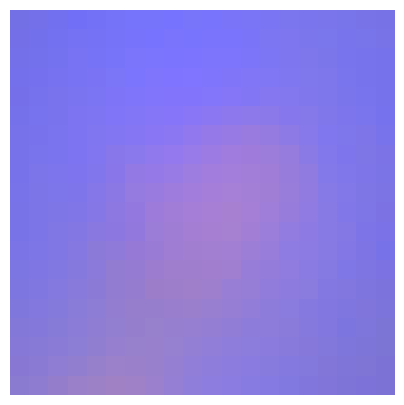

In [36]:
make_rgb_one_image(img_array=square_img, display_plot=True, type_plot='lupton')

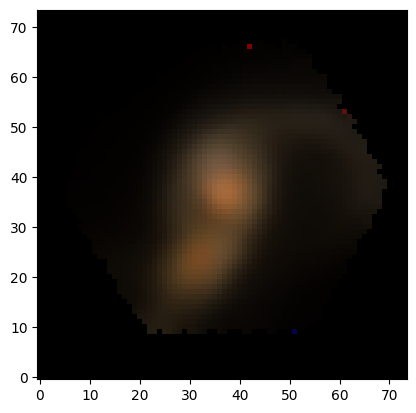

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.visualization import make_lupton_rgb
from astropy.io import fits
from astropy.utils.data import get_pkg_data_filename



rgb_default = make_lupton_rgb(img_t[0], img_t[1], img_t[2], filename='img.pn')
plt.imshow(rgb_default, origin='lower')